# Load libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets

In [2]:
train_df = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/train.csv")
test_df  = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/test.csv")

# Combine body + rule + subreddit into a single text field
train_df["text"] = train_df["body"] + " " + train_df["rule"] + " " + train_df["subreddit"]
test_df["text"]  = test_df["body"]  + " " + test_df["rule"]  + " " + test_df["subreddit"]

# TF-IDF Vectorization

In [3]:
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1,2))
X = tfidf.fit_transform(train_df["text"])
X_test = tfidf.transform(test_df["text"])
y = train_df["rule_violation"]

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# LightGBM Model

In [4]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

# Define the model
model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    num_leaves=128,
    learning_rate=0.05,
    n_estimators=2000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train with early stopping via callbacks
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[early_stopping(stopping_rounds=100), log_evaluation(100)]
)

[LightGBM] [Info] Number of positive: 825, number of negative: 798
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19326
[LightGBM] [Info] Number of data points in the train set: 1623, number of used features: 454
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508318 -> initscore=0.033275
[LightGBM] [Info] Start training from score 0.033275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=2000,
               num_leaves=128, objective='binary', random_state=42,
               subsample=0.8)

In [5]:
val_pred_proba = model.predict_proba(X_val)[:, 1]
val_pred = model.predict(X_val)


# Performance Metrics

Validation Accuracy: 0.7167487684729064
Precision: 0.7156398104265402
Recall: 0.7330097087378641
F1 Score: 0.724220623501199
ROC AUC: 0.8052427184466019

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71       200
           1       0.72      0.73      0.72       206

    accuracy                           0.72       406
   macro avg       0.72      0.72      0.72       406
weighted avg       0.72      0.72      0.72       406



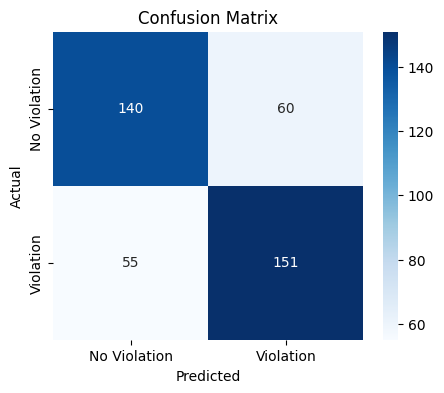

In [6]:
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Precision:", precision_score(y_val, val_pred))
print("Recall:", recall_score(y_val, val_pred))
print("F1 Score:", f1_score(y_val, val_pred))
print("ROC AUC:", roc_auc_score(y_val, val_pred_proba))
print("\nClassification Report:\n", classification_report(y_val, val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Violation","Violation"],
            yticklabels=["No Violation","Violation"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [7]:
test_pred_proba = model.predict(X_test)

submission = pd.DataFrame({
    "row_id": test_df["row_id"], 
    "rule_violation": test_pred_proba
})
submission.to_csv("submission.csv", index=False)
submission.head()

,row_id,rule_violation
0,2029,0
1,2030,0
2,2031,1
3,2032,1
4,2033,1
